<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/BERT_PR_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT - Perguntas e Respostas PR

### TL;DR
- Quando o BERT é aplicado na task de PR, em geral treinamos o modelo em um dataset similar ao Stanford Question and Answering (SQuAD). Nesse dataset, a Pergunta e um trecho que contém a resposta é enviado ao modelo e o BERT tem a função de encontrar o trecho do texto que contém a resposta. 

- Exemplos do SQuAD [aqui](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1).



![Input format for QA](http://www.mccormickml.com/assets/BERT/SQuAD/input_formatting.png)

#### As duas partes do texto são separadas pelo token especial `[SEP]`.

#### O BERT também usa "`Embeddings de segmento`" para diferenciar a pergunta do texto de referência. Estes são simplesmente dois embeddings (para os segmentos "`A`" e "`B`") que o BERT aprendeu e que adiciona aos embeddings de token antes de alimentá-los na camada de entrada

#### O BERT precisa destacar um "intervalo" de texto contendo a resposta - isso é representado simplesmente pela previsão de qual token marca o início da resposta e qual marca o fim.

![Iniciar classificação de token](http://www.mccormickml.com/assets/BERT/SQuAD/start_token_classification.png)


#### Para cada token no texto, alimentamos seu embedding final no classificador de token inicial. O classificador de token inicial tem apenas um único conjunto de pesos (representado pelo retângulo "inicial" azul na ilustração acima) que se aplica a cada palavra.

#### Depois de pegar o produto escalar entre os embeddings de saída e os pesos 'iniciais', aplicamos a ativação softmax para produzir uma distribuição de probabilidade sobre todas as palavras. A palavra que tiver a maior probabilidade de ser o token inicial é aquela que escolhemos.

#### Repetimos esse processo para o token final - com um outro vetor de peso.

![Terminar classificação de token](http://www.mccormickml.com/assets/BERT/SQuAD/end_token_classification.png)

# EXEMPLO

In [93]:
!pip install -q transformers

import torch 

#modelo
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

#tokenizador
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [94]:
question = "Qual o prazo mínimo para aumentar meu limite?"

answer_text = "O BERT foi treinado no dataset em inglês SQuAD e não possui \
relação com textos de aumento de limite. O prazo mínimo para \
aumento do limite é de 6 meses. Isso é desnecessário."

In [95]:
# Tokeniza o texto da pergunta e resposta
input_ids = tokenizer.encode(question, answer_text)

print(f'A entrada total possui {format(len(input_ids)):} tokens')

A entrada total possui 80 tokens


In [96]:
# O BERT somente precisa dos tokens IDs, porém, vamos inspecionar o comportamento do tokenizador.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Para cada token e seu id...
for token, id in zip(tokens, input_ids):
    
    # Se o token é [SEP], adiciona um espaço ao redor.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print os tokens como strings e os IDs em duas colunas.
    print(f'{token:<12} {id:>6,}')

    if id == tokenizer.sep_token_id:
        print('')    

[CLS]           101
qu           24,209
##al          2,389
o             1,051
pr           10,975
##az         10,936
##o           2,080
mini          7,163
##mo          5,302
para         11,498
au            8,740
##ment        3,672
##ar          2,906
me            2,033
##u           2,226
limit         5,787
##e           2,063
?             1,029

[SEP]           102

o             1,051
bert         14,324
f             1,042
##oi         10,448
tre          29,461
##ina         3,981
##do          3,527
no            2,053
data          2,951
##set        13,462
em            7,861
ing          13,749
##les         4,244
squad         4,686
e             1,041
na            6,583
##o           2,080
po           13,433
##ss          4,757
##ui         10,179
re            2,128
##la          2,721
##cao        20,808
com           4,012
text          3,793
##os          2,891
de            2,139
au            8,740
##mento      23,065
de            2,139
limit         5,78

#### Nós concatenamos a `Pergunta` e `texto com a resposta` juntos, mas o BERT ainda precisa de uma maneira de distingui-los. O BERT tem dois embeddings especiais de "Segmento", um para o segmento "`A`" e outro para o segmento "`B`". Antes que a palavra embeddings vá para as camadas BERT, o segmento de embedding `A` precisa ser adicionado aos tokens da `Pergunta`, e o segmento de embedding `B` precisa ser adicionado a cada um dos tokens `texto com resposta`.

#### Essas adições são tratadas pela biblioteca `transformer`, e tudo o que precisamos fazer é especificar um '`0`' ou '`1`' para cada token.

#### Nota: A biblioteca `transformers` denota os embeddings de segmento por `token_type_ids`

In [97]:
# Pesquise os input_ids para a primeira instância do token [SEP].
sep_index = input_ids.index(tokenizer.sep_token_id)

# O nro de tokens de segmento A inclui o token [SEP].
num_seg_a = sep_index + 1

# A sobra é o segmento B.
num_seg_b = len(input_ids) - num_seg_a

# Uma lista de 0s and 1s para os segmentos.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# Verifica se os tamanhos estão corretos
assert len(segment_ids) == len(input_ids)

### Observação lateral: onde está o padding?

> ####  O [código de exemplo original](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering) não executa nenhum padding (note que estamos alimentando apenas 1 *exemplo*). Se, em vez disso, inserirmos um batch de exemplos, precisaremos do padding e máscara de atenção para dizer ao BERT para ignorar os tokens de paddings.

####  Vamos alimentar o modelo com o nosso exemplo



In [98]:
start_scores, end_scores = model(
    torch.tensor([input_ids]), 
    token_type_ids=torch.tensor([segment_ids])) 

#### A resposta é selecionada pelos scores (probabilidades) mais altos da palavra de início e fim da resposta. 

In [99]:
# Encontrar os tokens com o maior score de início e fim.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combinar os tokens da resposta e printar.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "o pr ##az ##o mini ##mo para au ##mento do limit ##e e de 6 me ##ses"


#### Parece correto, vamos reconstruir o texto das subwords.

> #### **Nota**: É um pouco ingênuo escolher os scores mais altos da palavra de início e fim. Um problema desse raciocínio é que podemos pensar que possa existir uma predição de palavra final que está antes da palavra inicial?! Um raciocínio mais refinado do que de fato acontece é a escolha de score total mais alta fim $\geq$ início (monótona não decrescente).

In [100]:
# Começa com o token de inicio.
answer = tokens[answer_start]

# Seleciona o resto dos tokens da resposta.
for i in range(answer_start + 1, answer_end + 1):
    
    # Se o token é uma subword, entao recombinamos com o token anterior.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Se não, adiciona um espaço ao token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "o prazo minimo para aumento do limite e de 6 meses"


## Visualização  dos scores

I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (16,8)

### Recuperando todas os scores iniciais e finais e todos os tokens rótulados no eixo x.

In [102]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


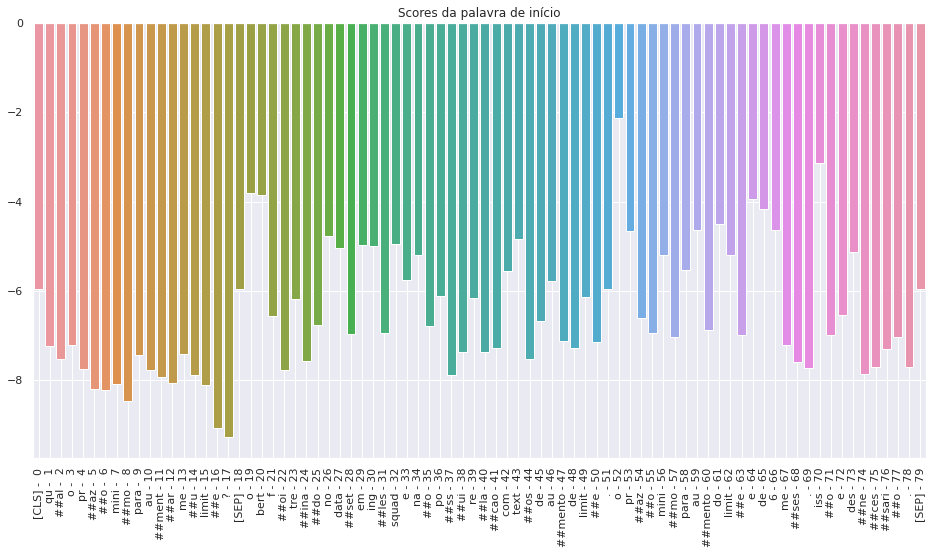

In [103]:
# Cria um barplot que mostra o início do score da palavra para todos os tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# xlabels na vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Adiciona grid vertical.
ax.grid(True)

plt.title('Scores da palavra de início')

plt.show()

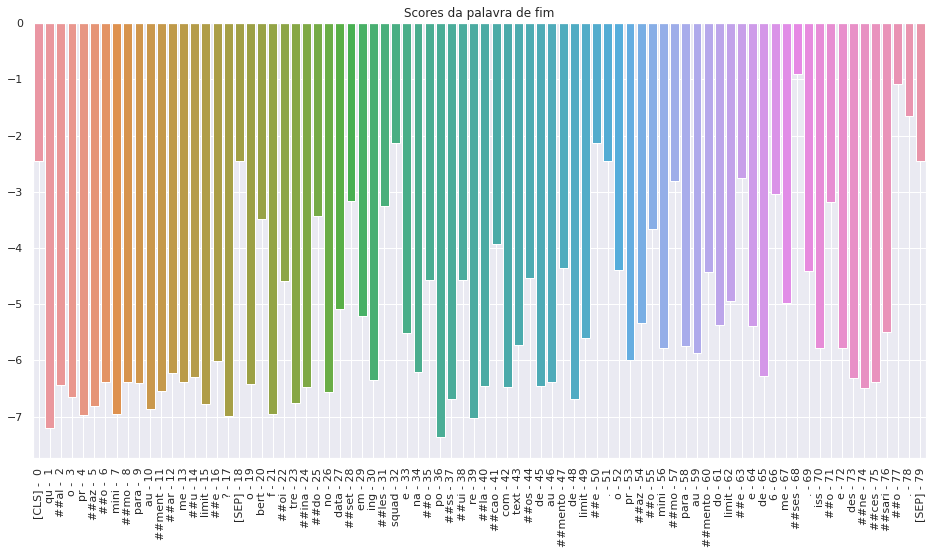

In [104]:
# Cria um barplot que mostra o início do score da palavra para todos os tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# xlabels na vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Adiciona grid vertical.
ax.grid(True)

plt.title('Scores da palavra de fim')

plt.show()

### Visão Alternativa

#### Pontuações inicial e final em um gráfico de barra única

In [105]:
import pandas as pd

# Armazena os tokens e scores em um DataFrame. Cada token terá duas linhas, uma para 
# a pontuação inicial e outra para o final, a coluna "marcador" irá diferenciá-los.
for (i, token_label) in enumerate(token_labels):

    # Adiciona os tokens de inicio como uma única linha.
    scores.append({'tokens': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Adiciona os tokens do fim com uma outra linha.
    scores.append({'tokens': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)

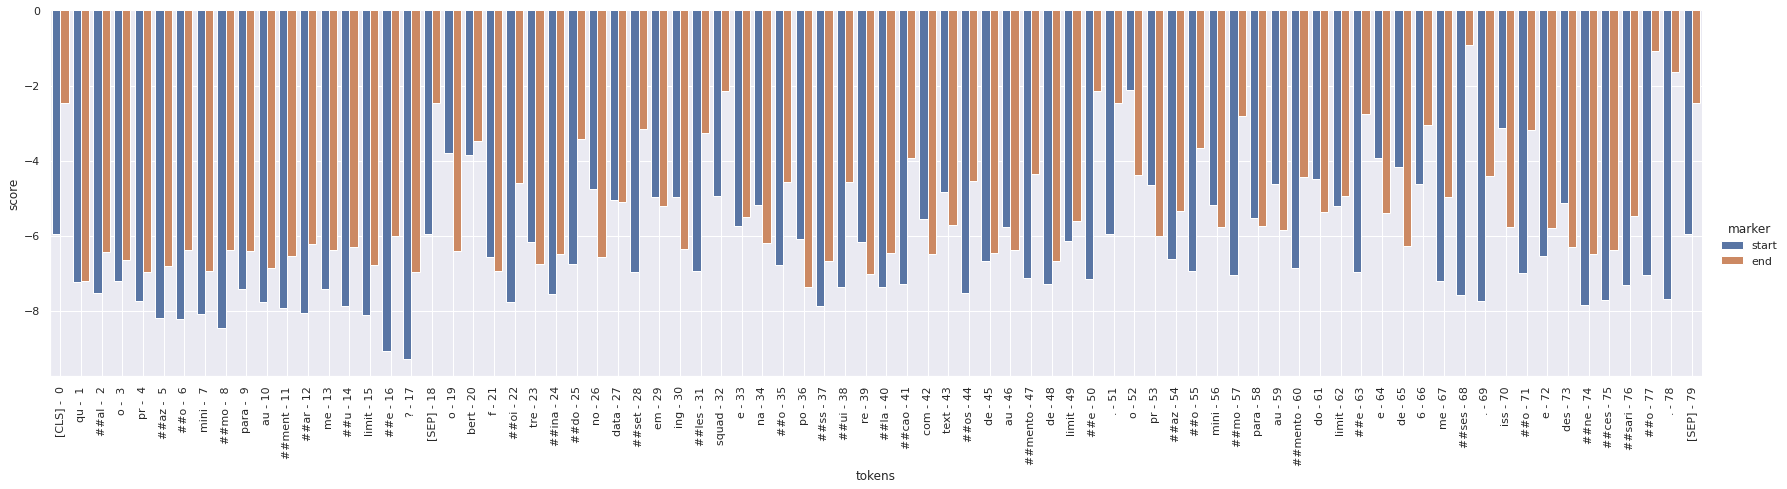

In [106]:
g = sns.catplot(x="tokens", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

g.ax.grid(True)

## Mais Exemplos

#### Criar uma função para testes mais rápidos.

In [107]:
def answer_question(question, answer_text):
    '''
    Toma uma string `pergunta` e uma string `texto que contém a resposta`, e 
    identifica as palavras dentro do `answer_text` que são a resposta. Imprime-os.
    '''
    # ======== Tokeniza ========
    # Aplica o tokenizador no texto da entrada, tradando-o como um text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Imprime o tamanho da sequência.
    print(f'A query tem {format(len(input_ids)):} tokens.\n')

    # ======== Configura o Segment IDs ========
    # Procura no input_ids o token [SEP].
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # configura o número de segments A que inclui o token [SEP].
    num_seg_a = sep_index + 1

    # o resto é o segumento B.
    num_seg_b = len(input_ids) - num_seg_a

    # estrutura o segment_ids em uma lista de 0s e 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # confere se os tamanhos estão corretos.
    assert len(segment_ids) == len(input_ids)

    # ======== Avalia ========
    # roda o examplo no modelo.
    start_scores, end_scores = model(
        torch.tensor([input_ids]), 
        token_type_ids=torch.tensor([segment_ids]))

    # ======== Reconstrói a resposta ========
    # Encontra os tokens com o score mais alto de inicio e fim.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Converte os ids para string.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Começa com o token de inicio.
    answer = tokens[answer_start]

    # Seleciona o resto da resposta.
    for i in range(answer_start + 1, answer_end + 1):
        
        # Se é um token de subword, então recombina com o token anterior.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Se não, adiciona um espaço ao token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [168]:
new_text = "Se o seu cartão foi furtado ou roubado, você precisa entrar em contato \
com a central de cartões, os telefones são 00-12345-7890 ou 0800-123-00000. Você \
também pode entrar em contato por whatsapp com os nossos operadores nos seguintes \
horários: 06h00 até as 22h30 de Segunda a Segunda. Aqui é somente uma frase sem \
conexão com o texto, alias vale enfatizar que os textos de respostas podem ter até \
512 tokens. Se precisa de maiores esclarecimentos, por favor aguarde. Voldemort é \
o vilão! Voldermort sempre lança o feitiço avada-kedavra. Porém, Harry Potter \
conseguiu vencer a batalha final. Por que o C3PO estava com o braço vermelho no 7o \
filme de Star Wars? O novo Hulk não parece o Hulk."

print(len(new_text))

690


-----------------------------
#### Criando uma pergunta para o BERT: 

In [169]:
question = "Qual o telefone?"
answer_question(question, new_text)

A query tem 255 tokens.

Answer: "sao 00 - 12345 - 7890 ou 0800 - 123 - 00000"


In [170]:
question = "Quantos tokens?"
answer_question(question, new_text)

A query tem 253 tokens.

Answer: "512"


In [171]:
question = "Cor do braço do C3PO?"
answer_question(question, new_text)

A query tem 258 tokens.

Answer: "vermelho no 7o filme de star wars"


In [172]:
question = "Quão poder o BERT possui?"
answer_question(question, new_text)

A query tem 258 tokens.

Answer: "[CLS]"


# FIM